In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
# data = np.array(data)
# labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [3]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  300
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [ ]:
def resize(img, target_height, target_width):
    height, width = img.shape
    resized_img = np.zeros((target_height, target_width), dtype=np.uint8)
    
    scale_x = width / target_width
    scale_y = height / target_height

    for i in range(target_height):
        for j in range(target_width):
            orig_x = min(int(j * scale_x), width - 1)
            orig_y = min(int(i * scale_y), height - 1)
            resized_img[i, j] = img[orig_y, orig_x]

    return resized_img

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = (img - min_val) / (max_val - min_val) * 255
    return normalized_img.astype(np.uint8)

kernelm_3 = np.full((3,3), 1/9)


def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
    
    return median

def median_filter(image, kernel):
    height_image, width_image = image.shape
    height_kernel, width_kernel = kernel.shape

    height_center = int((height_kernel - 1) / 2)
    width_center = int((width_kernel - 1) / 2)

    left_padding = width_center
    right_padding = width_kernel - width_center
    top_padding = height_center
    bottom_padding = height_kernel - height_center

    padded_image = np.pad(image, ((left_padding, right_padding), (top_padding, bottom_padding)), mode='edge')

    result = np.zeros([height_image, width_image])

    for i in range(height_image):
        for j in range(width_image):
            temp = np.zeros(len(kernel) * len(kernel))
            index = 0
            for k in range(height_kernel):
                for l in range(width_kernel):
                    temp[index] = padded_image[i+k, j+l]
                    index += 1
            result[i, j] = median(temp) 

    return result

def hsv_segmentation(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Warna daun hijau
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    # Warna bercak coklat/kuning tua
    lower_brown = np.array([10, 50, 20])
    upper_brown = np.array([30, 255, 200])

    # Masking kedua warna
    mask_green = cv.inRange(hsv_img, lower_green, upper_green)
    mask_brown = cv.inRange(hsv_img, lower_brown, upper_brown)

    # Gabungkan kedua mask
    mask_combined = cv.bitwise_or(mask_green, mask_brown)

    # Terapkan mask ke gambar asli
    result = cv.bitwise_and(img, img, mask=mask_combined)
    return result



def percobaan_1(img, target_height, target_width):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized_img = resize(gray_img, target_height, target_width)
    normalize_img = normalize(resized_img)
    return normalize_img

def percobaan_2(img, target_height, target_width):
    percobaan_1_img = percobaan_1(img, target_height, target_width)
    percobaan_1_img_uint8 = (percobaan_1_img * 255).astype(np.uint8)
    median_img = median_filter(percobaan_1_img_uint8, kernelm_3)
    median_img_float = median_img.astype(np.float32) / 255
    return median_img_float


def percobaan_3(img, target_height, target_width):
    segmented_img = hsv_segmentation(img)
    percobaan_2_img = percobaan_2(segmented_img, target_height, target_width)
    
    # Konversi ke grayscale
    #gray_img = cv.cvtColor(segmented_img, cv.COLOR_BGR2GRAY)
    #resized_img = resize(gray_img, target_height, target_width)
    
    # Normalisasi
    #normalize_img = normalize(resized_img)
    
    # Filter median
    #median_img = median_filter(normalize_img, kernelm_3)
    
    return percobaan_2_img



### Preprocessing

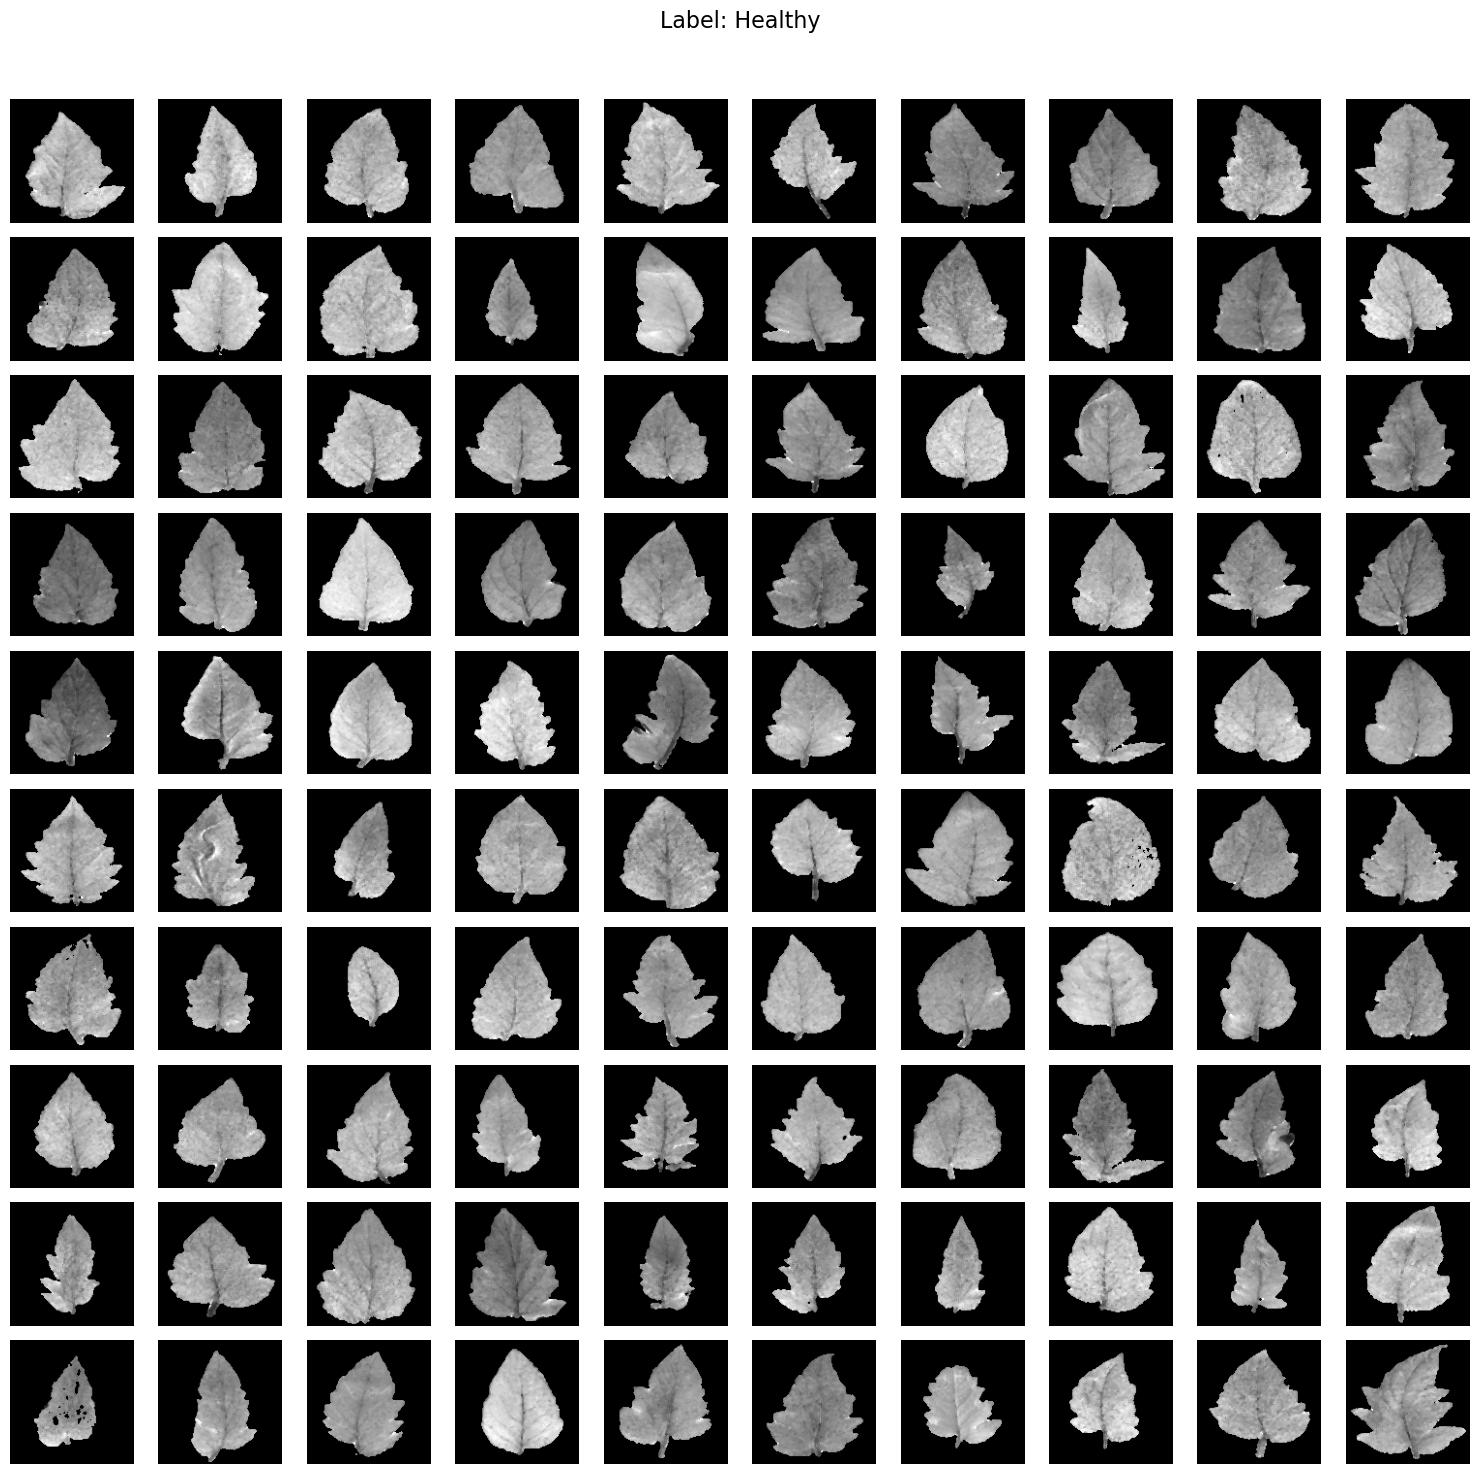

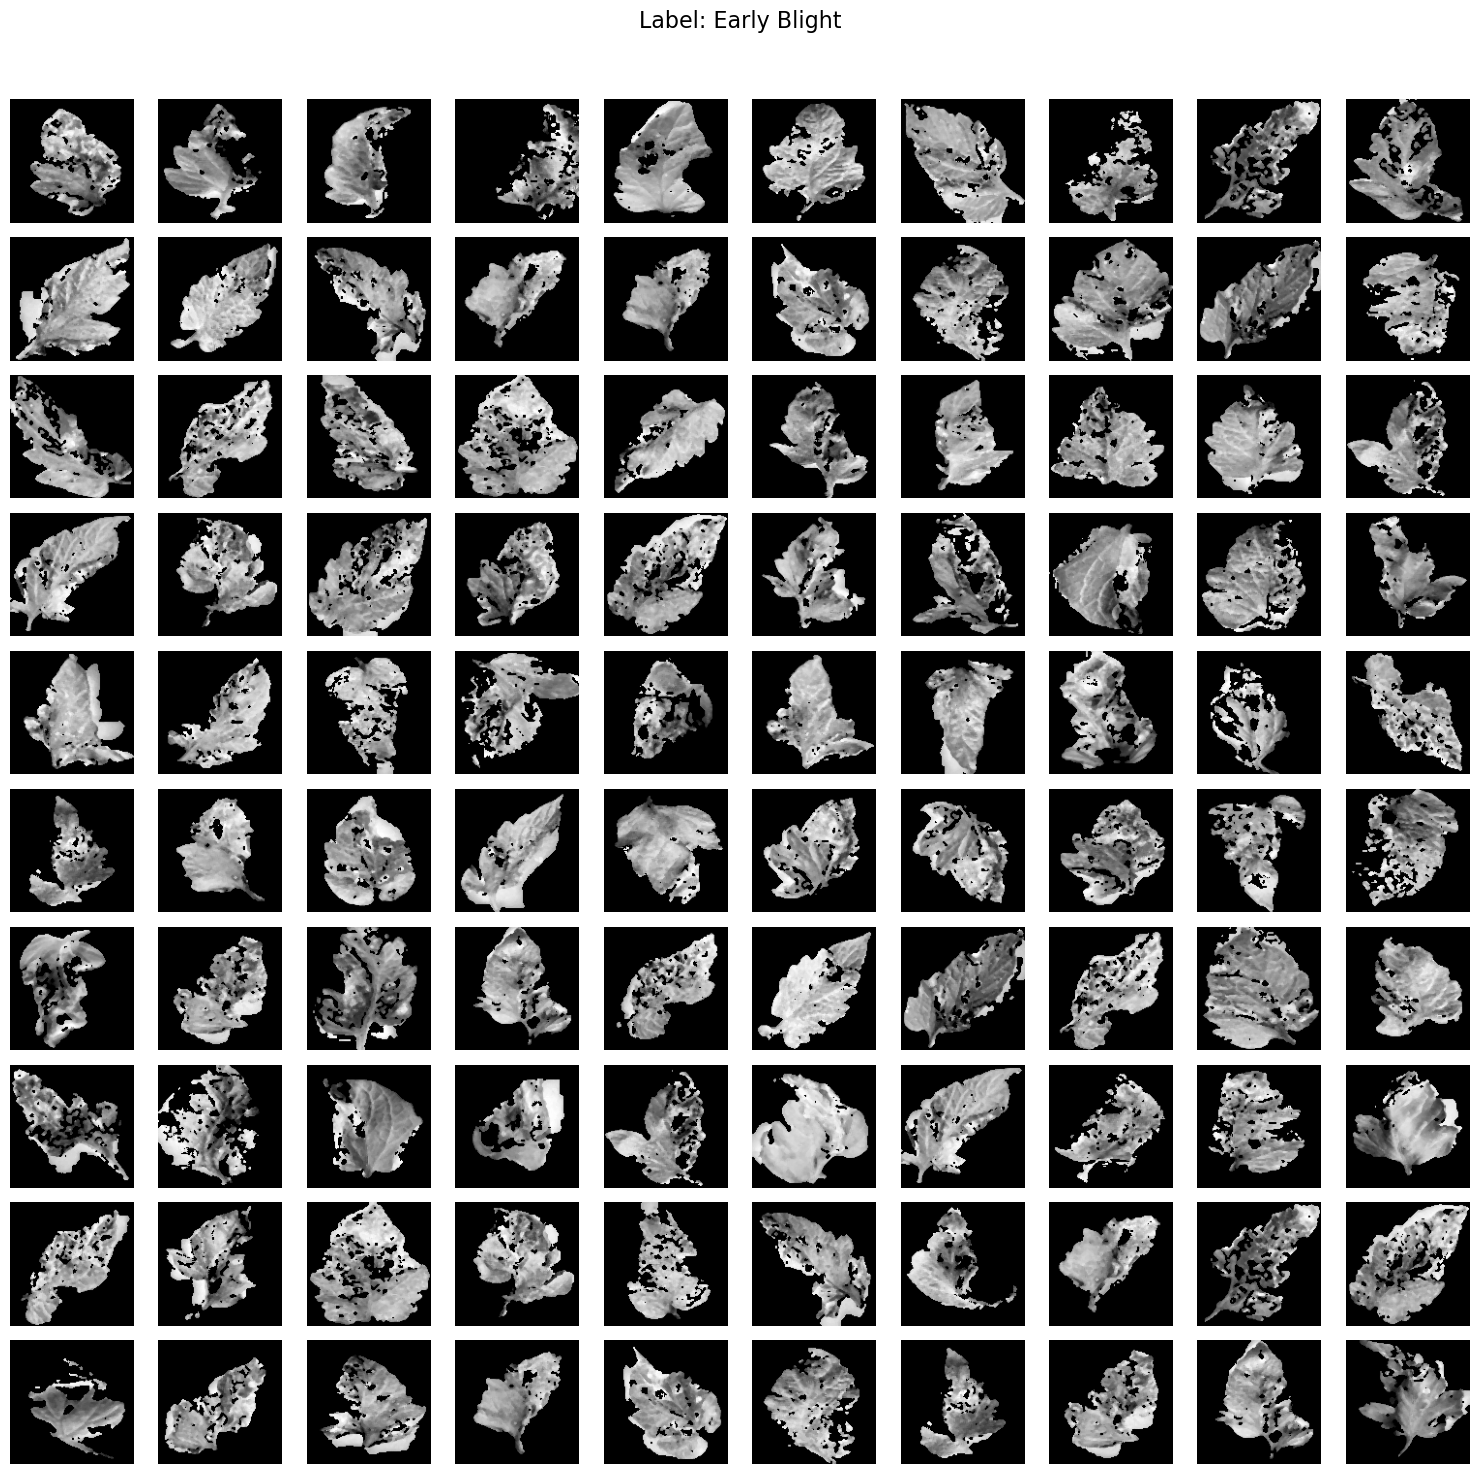

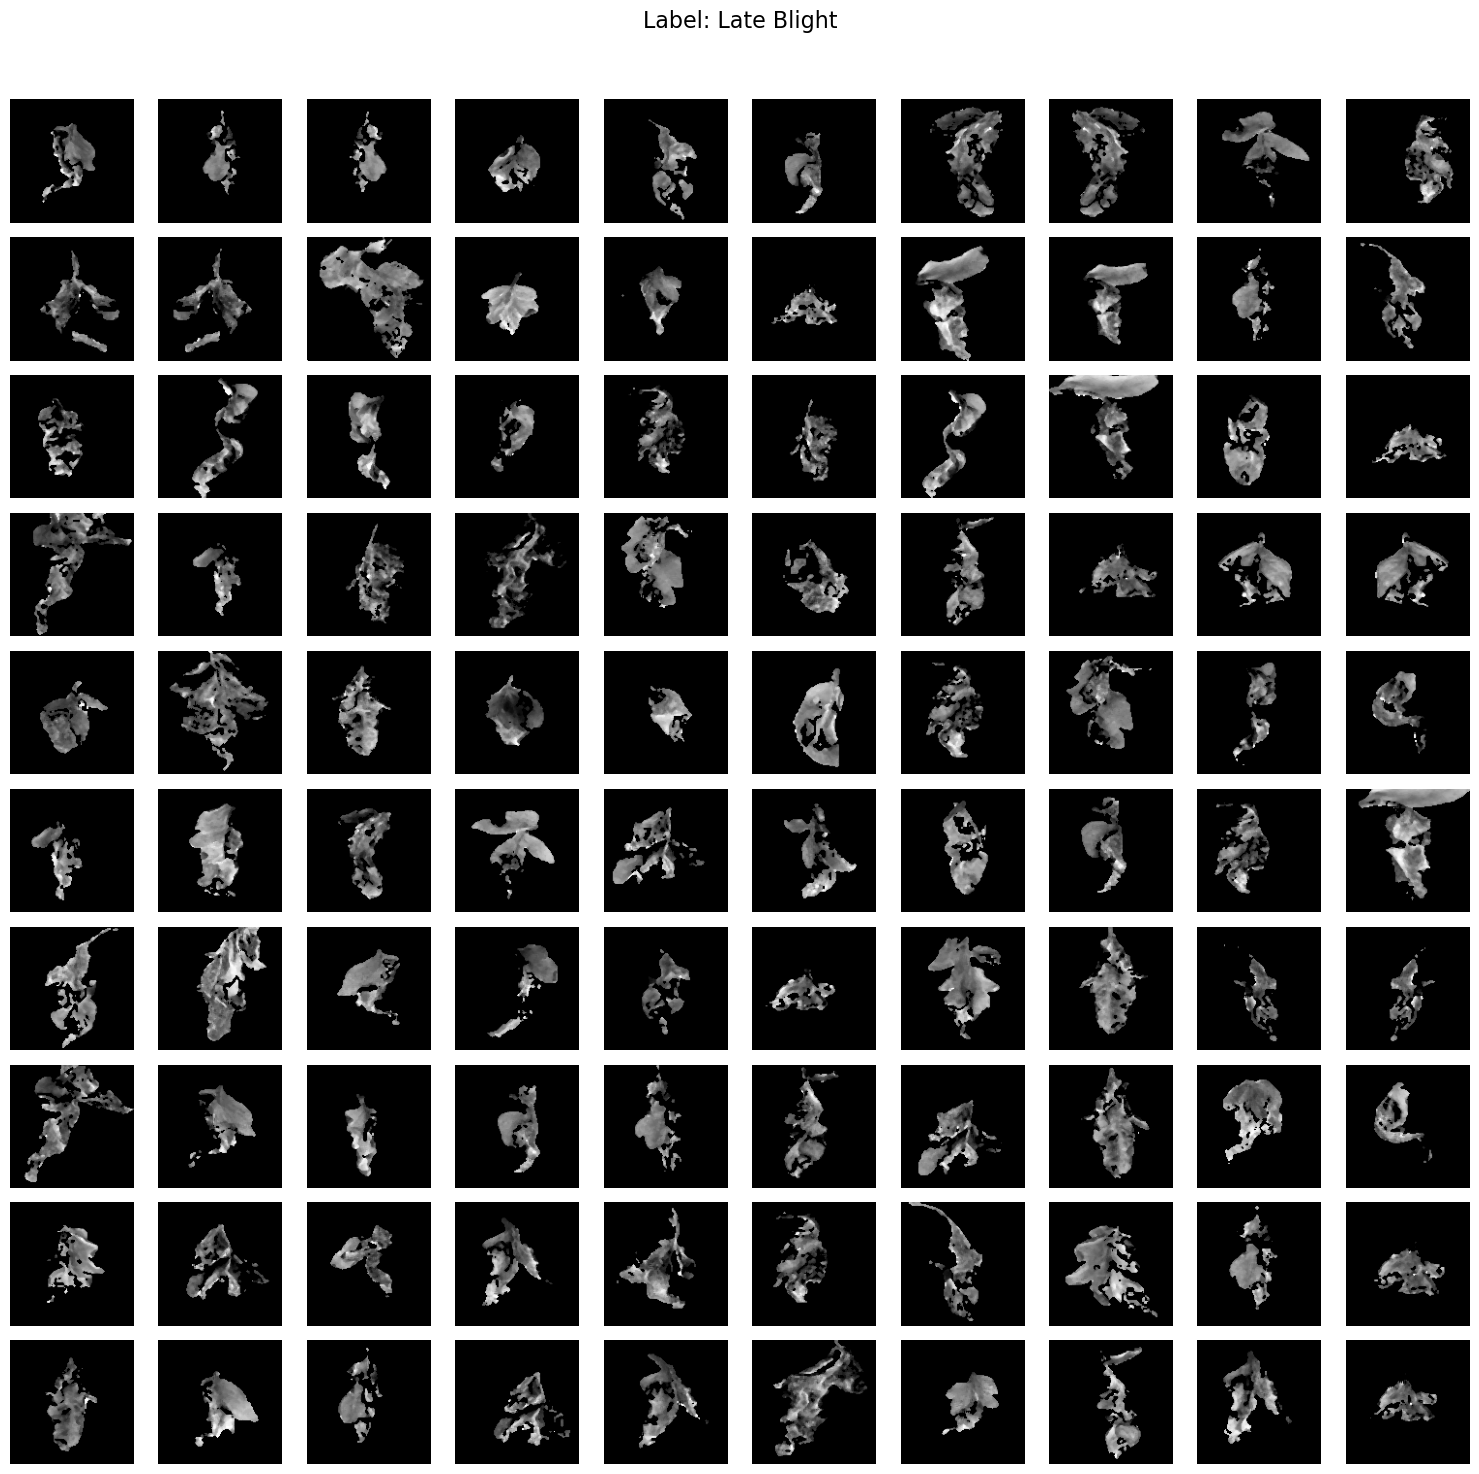

In [6]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = [percobaan_3(img, 128, 128) for img in data]
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)

label_names = {
    "Label 1": "Healthy",
    "Label 2": "Early Blight",
    "Label 3": "Late Blight"
}

# Loop untuk setiap label untuk tampilkan hasil preprocessing grayscale
for label_code in label_names:
    idxs = np.where(labels == label_code)[0][:100]

    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Label: {label_names[label_code]}", fontsize=16)

    for i, idx in enumerate(idxs):
        plt.subplot(10, 10, i + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()



### Feature Extraction

In [7]:
def glcm(image, derajat):
    image = (image * 255).astype(np.uint8)  
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [8]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [9]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [10]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [11]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [12]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [13]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [14]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [15]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [16]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [17]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [18]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [19]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [20]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [21]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [22]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [23]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [24]:
# Gabungkan semua fitur dari setiap citra ke dalam satu array fitur per gambar
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        correlation0[i], correlation45[i], correlation90[i], correlation135[i],
        dissimilarity0[i], dissimilarity45[i], dissimilarity90[i], dissimilarity135[i],
        Kontras0[i], Kontras45[i], Kontras90[i], Kontras135[i],
        homogenity0[i], homogenity45[i], homogenity90[i], homogenity135[i],
        entropy0[i], entropy45[i], entropy90[i], entropy135[i],
        ASM0[i], ASM45[i], ASM90[i], ASM135[i],
        energy0[i], energy45[i], energy90[i], energy135[i],
    ]
    features.append(fitur)

# Ubah menjadi numpy array agar bisa digunakan di ML model
features = np.array(features)
labels = np.array(labels)


### Write the extraction's results to CSV 

In [25]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak


Filename    Label   Contrast0  \
0    c1c04a55-0dd5-48e2-9cc6-76bbcc1899fd___GH_HL L...  Label 1  132.835753   
1    c1dfd66e-7c0c-40a7-8280-0aa1aaf5436b___GH_HL L...  Label 1  139.727731   
2    c2c1758f-3576-4e8a-9853-5f11ac4d20d6___GH_HL L...  Label 1  140.282726   
3    c6acee22-6c56-41a8-ae90-26c6064e0261___GH_HL L...  Label 1  163.290969   
4    c7cedd2f-dfae-4232-9cab-d75197d48948___GH_HL L...  Label 1  202.738189   
..                                                 ...      ...         ...   
295  f3c203d3-4246-4af5-adfd-37452f637024___GHLB2 L...  Label 3  196.626230   
296  f3e53136-750b-4394-96fe-0cd8c2f747bc___GHLB2 L...  Label 3  126.075541   
297  f4ab4184-4d1b-4b06-83bd-6324281c8588___GHLB2 L...  Label 3  217.219365   
298  f66e2c13-dd22-4277-8c73-ff987bc19064___GHLB2 L...  Label 3  278.791708   
299  f68ecc9a-4ac2-4dde-b2bb-97f2c438ffd8___GHLB2 L...  Label 3  125.685408   

     Contrast45  Contrast90  Contrast135  Homogeneity0  Homogeneity45  \
0    220.580941  150.819021   199.372435      0.733510       0.685347   
1    170.034968  102.903051   196.252713      0.797639       0.764999   
2    203.724843  128.351009   191.674995      0.732864       0.686820   
3    229.192758  150.354946   245.313783      0.744139       0.697777   
4    332.046500  255.979331   347.416951      0.704465       0.653307   
..          ...         ...          ...           ...            ...   
295  388.727199  231.048782   272.036022      0.787162       0.754393   
296  223.115878  154.703002   186.451857      0.908452       0.893778   
297  327.553599  226.308317   317.744559      0.889341       0.872470   
298  361.859260  217.461368   374.463885      0.875101       0.861010   
299  211.426003  133.891117   179.487879      0.920121       0.908432   

     Homogeneity90  Homogeneity135  ...     ASM90    ASM135   Energy0  \
0         0.734384        0.691251  ...  0.349999  0.343441  0.592104   
1         0.802404        0.761173  ...  0.489031  0.479851  0.697334   
2         0.735923        0.690297  ...  0.353518  0.346424  0.593354   
3         0.740842        0.695670  ...  0.350902  0.342639  0.591289   
4         0.702244        0.655722  ...  0.314050  0.306830  0.561828   
..             ...             ...  ...       ...       ...       ...   
295       0.782791        0.763067  ...  0.531703  0.524094  0.730964   
296       0.907013        0.894005  ...  0.763391  0.758945  0.874400   
297       0.887789        0.873992  ...  0.737170  0.728891  0.859017   
298       0.884679        0.861961  ...  0.718385  0.705995  0.844560   
299       0.920768        0.908969  ...  0.806207  0.800984  0.898751   

     Energy45  Energy90  Energy135  Correlation0  Correlation45  \
0    0.585525  0.591607   0.586038      0.976865       0.961687   
1    0.694142  0.699308   0.692713      0.972831       0.967090   
2    0.587518  0.594574   0.588578      0.973154       0.961119   
3    0.585666  0.592370   0.585354      0.973256       0.962561   
4    0.554532  0.560401   0.553923      0.975205       0.959470   
..        ...       ...        ...           ...            ...   
295  0.719975  0.729180   0.723943      0.933504       0.869271   
296  0.869935  0.873723   0.871174      0.945893       0.904901   
297  0.852822  0.858586   0.853751      0.907351       0.861239   
298  0.840855  0.847576   0.840235      0.913115       0.887989   
299  0.894048  0.897891   0.894977      0.903604       0.839001   

     Correlation90  Correlation135  
0         0.973733        0.965370  
1         0.979991        0.962016  
2         0.975438        0.963419  
3         0.975374        0.959927  
4         0.968694        0.957594  
..             ...             ...  
295       0.921842        0.908514  
296       0.933607        0.920528  
297       0.903474        0.865394  
298       0.932229        0.884088  
299       0.897311        0.863321  

[300 rows x 30 columns]

### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

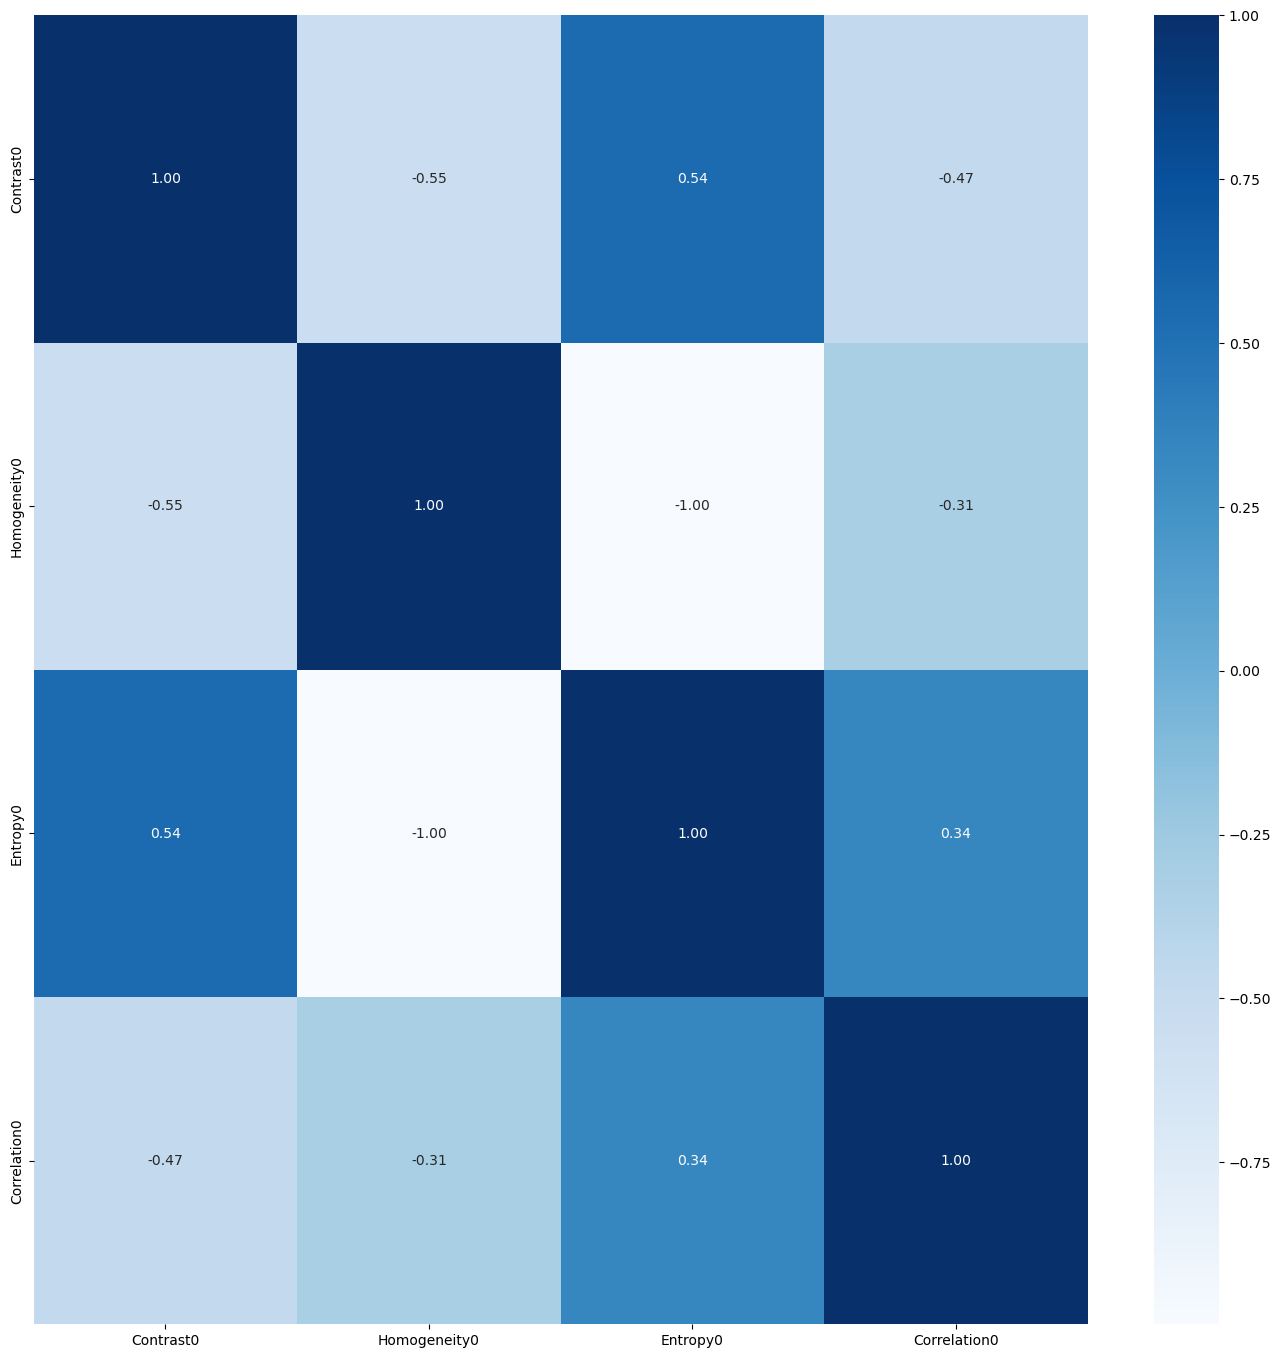

In [26]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

#### Method ANOVA

<Axes: >

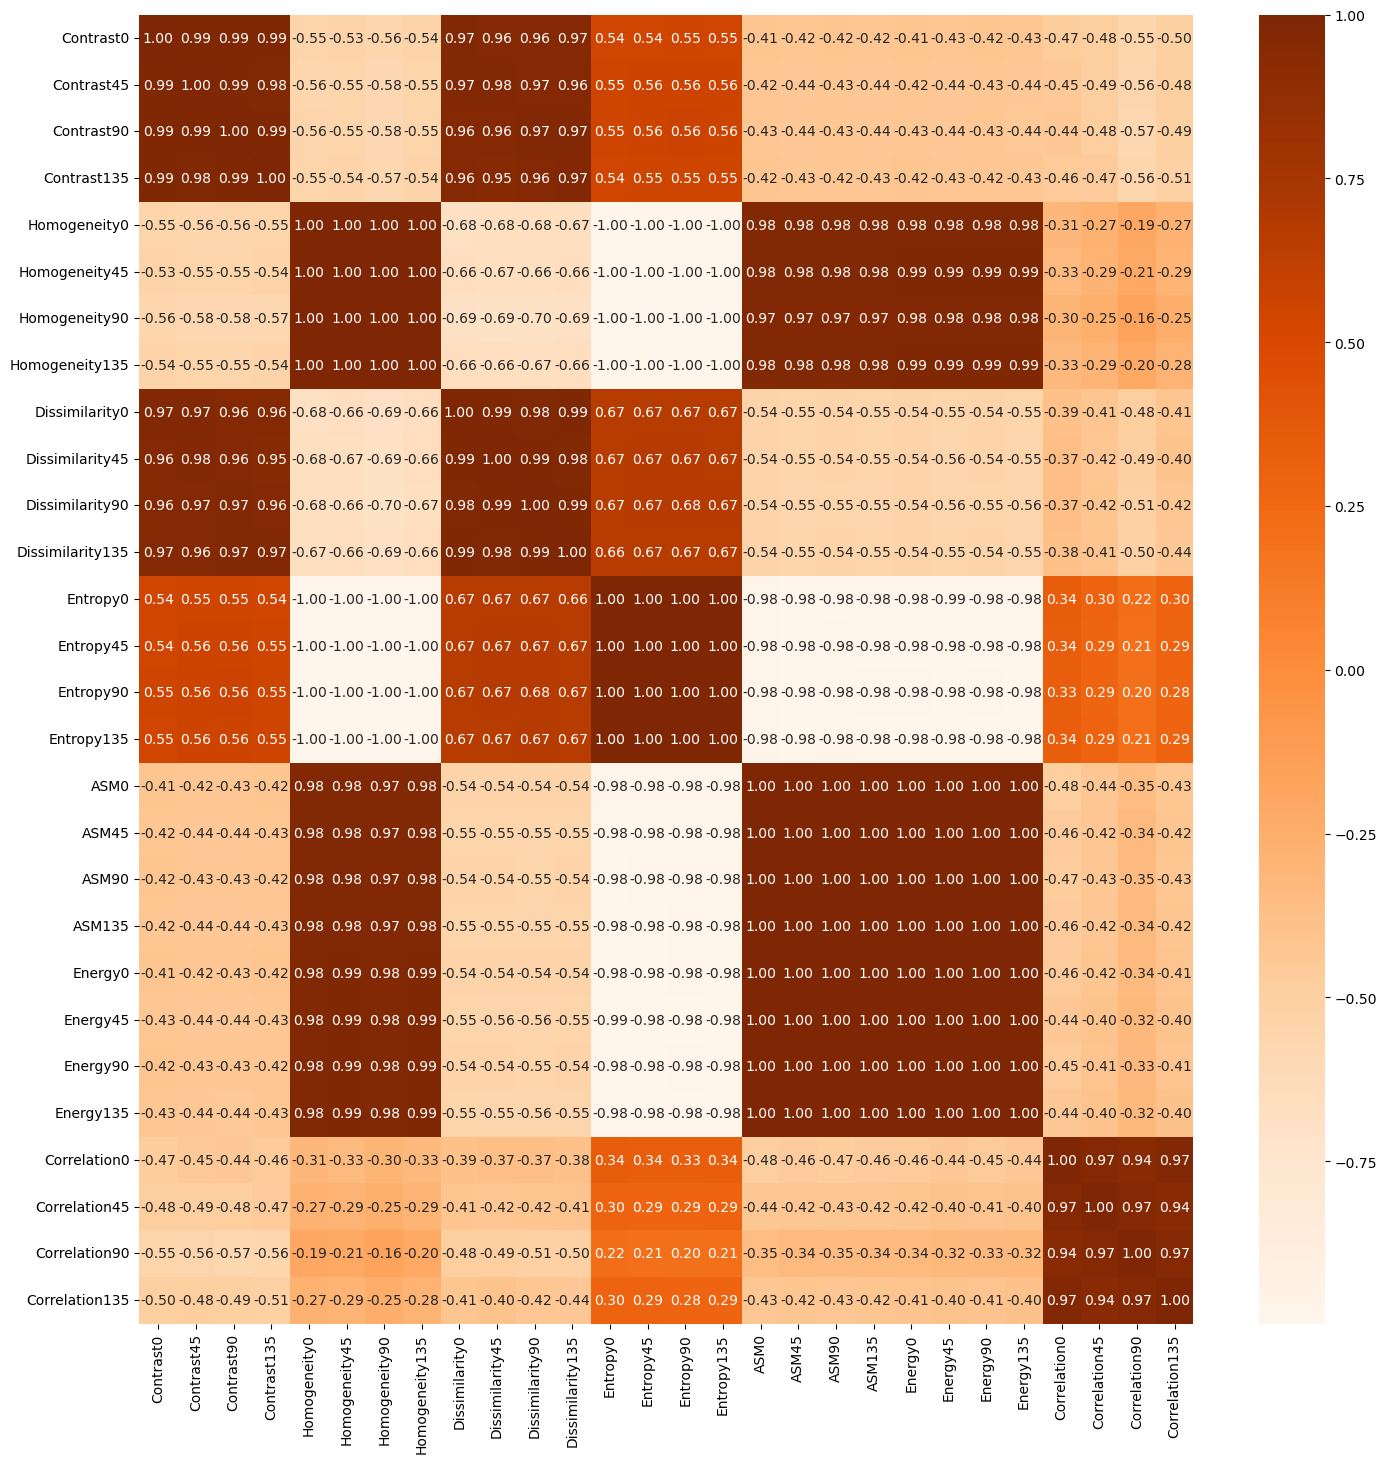

In [27]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

# Hitung nilai ANOVA F-score untuk setiap fitur
anova_selector = SelectKBest(score_func=f_classif, k='all')  # 'all' agar kita dapat semua skor
anova_selector.fit(X, y)

# Ambil skor dan nama fitur
anova_scores = anova_selector.scores_
feature_names = X.columns

# Threshold manual (contoh: hanya ambil fitur dengan skor > 5)
threshold = 5
selected_features = feature_names[anova_scores > threshold]

# Tampilkan fitur yang lolos seleksi
x_new = X[selected_features]
x_new

plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Oranges', fmt=".2f")


## Splitting Data

In [28]:
# Memisahkan data menjadi data latih dan data uji
# test_size=0.2 artinya 20% data untuk pengujian, 80% untuk pelatihan
# random_state untuk memastikan hasil konsisten setiap kali dijalankan
# stratify=y memastikan distribusi label tetap seimbang antara train dan test
X_train, X_test, y_train, y_test = train_test_split(
    x_new, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)


Data Latih: (240, 28)
Data Uji: (60, 28)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [29]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

### Min-Max Scaling

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

### Define Model

In [31]:
def generateClassificationReport(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("Accuracy:", accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [32]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred_train = rf.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = rf.predict(X_test)
generateClassificationReport( y_test, y_pred_test)

------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.99      1.00      0.99        80
     Label 2       1.00      0.99      0.99        80
     Label 3       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Confusion Matrix:
[[80  0  0]
 [ 1 79  0]
 [ 0  0 80]]
Accuracy: 0.9958333333333333

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       1.00      1.00      1.00        20
     Label 2       1.00      1.00      1.00        20
     Label 3       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
Acc

### Train SVM Classifier

In [33]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = svm.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = svm.predict(X_test)
generateClassificationReport( y_test, y_pred_test)


------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       1.00      0.99      0.99        80
     Label 2       0.96      1.00      0.98        80
     Label 3       0.99      0.96      0.97        80

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

Confusion Matrix:
[[79  0  1]
 [ 0 80  0]
 [ 0  3 77]]
Accuracy: 0.9833333333333333

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       1.00      1.00      1.00        20
     Label 2       1.00      1.00      1.00        20
     Label 3       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
Ac

### Train KNN Classifier

In [34]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = knn.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = knn.predict(X_test)
generateClassificationReport( y_test, y_pred_test)



------Training Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       0.99      1.00      0.99        80
     Label 2       0.96      1.00      0.98        80
     Label 3       1.00      0.95      0.97        80

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

Confusion Matrix:
[[80  0  0]
 [ 0 80  0]
 [ 1  3 76]]
Accuracy: 0.9833333333333333

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

     Label 1       1.00      1.00      1.00        20
     Label 2       1.00      1.00      1.00        20
     Label 3       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]
Ac

## Evaluation With Confusion Matrix

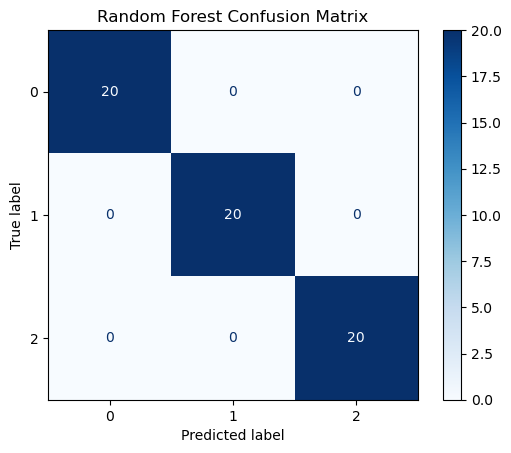

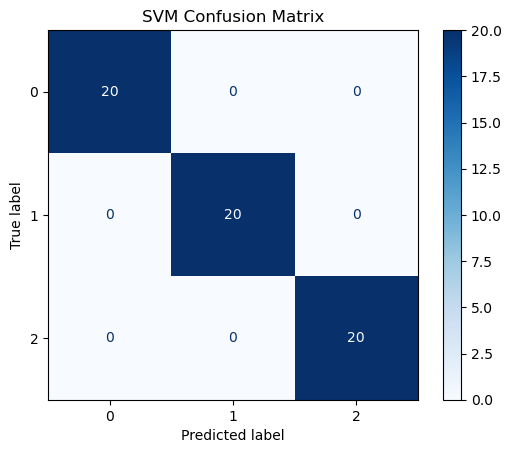

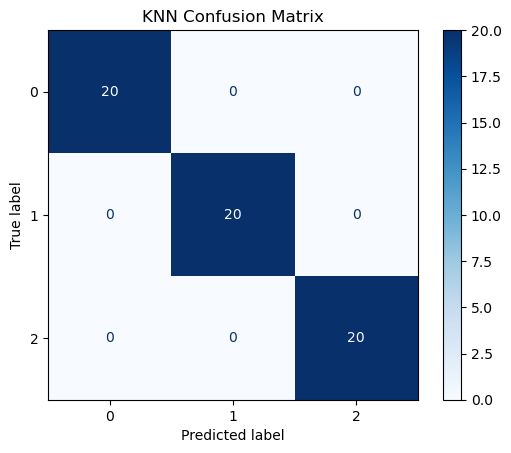

In [35]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")